### A notebook to study the extrema calculations in isaura
for blob determination

In [7]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize

pd.set_option('display.max_rows', 200)

import imageio

from next_misc.toolbox import functions as func


In [12]:
# provide file_path here
#file_path = 'example_files/sophronia_27_208Tl.h5'
file_path = '/home/e78368jw/Downloads/tmp_out/testing_arena/rel_0.2/isaura_100_208Tl.h5'

df = pd.read_hdf(file_path, 'MC/particles')
events = np.unique(df.event_id.to_numpy())
evt = events[199]
print("Selected event: {} ({})".format(evt, evt*2))

# load in MC hits
df_ps = df[df.event_id == evt]
true_info = mcio.load_mchits_df(file_path).reset_index()

this_evt_true_info = true_info[true_info.event_id == evt]

def return_id(number):
    return str(df_ps[df_ps.particle_id == number].particle_name.values).strip("'[]'")

this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)


Selected event: 990201 (1980402)


/tmp/ipykernel_19636/307038752.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)


### Load the hit information that isaura uses

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
1769528,1980402,1.980403e+12,0,-25.70022,114.984505,0,-75.125,88.575,0.0,0.0,352.879209,0.000024,0.000024,-1.0,0.000024,0,0.000024
1769529,1980402,1.980403e+12,0,-25.70022,114.984505,0,-75.125,89.575,0.0,0.0,352.879209,0.000024,0.000024,-1.0,0.000024,0,0.000024
1769530,1980402,1.980403e+12,0,-25.70022,114.984505,0,-74.125,86.575,0.0,0.0,352.879209,0.000025,0.000025,-1.0,0.000025,0,0.000025
1769531,1980402,1.980403e+12,0,-25.70022,114.984505,0,-74.125,87.575,0.0,0.0,352.879209,0.000031,0.000031,-1.0,0.000031,0,0.000031
1769532,1980402,1.980403e+12,0,-25.70022,114.984505,0,-74.125,88.575,0.0,0.0,352.879209,0.000033,0.000033,-1.0,0.000033,0,0.000033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1781852,1980402,1.980403e+12,0,-25.70022,114.984505,0,6.875,112.575,0.0,0.0,433.460508,0.000012,0.000012,-1.0,0.000012,0,0.000012
1781853,1980402,1.980403e+12,0,-25.70022,114.984505,0,6.875,113.575,0.0,0.0,433.460508,0.000014,0.000014,-1.0,0.000014,0,0.000014
1781854,1980402,1.980403e+12,0,-25.70022,114.984505,0,6.875,114.575,0.0,0.0,433.460508,0.000013,0.000013,-1.0,0.000013,0,0.000013
1781855,1980402,1.980403e+12,0,-25.70022,114.984505,0,6.875,115.575,0.0,0.0,433.460508,0.000010,0.000010,-1.0,0.000010,0,0.000010


X maximum and minimum
35.875 -80.125

Y maximum and minimum
165.575 80.57499999999999

Z maximum and minimum
433.46050781250005 352.8792093750001


/tmp/ipykernel_19636/2144595122.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


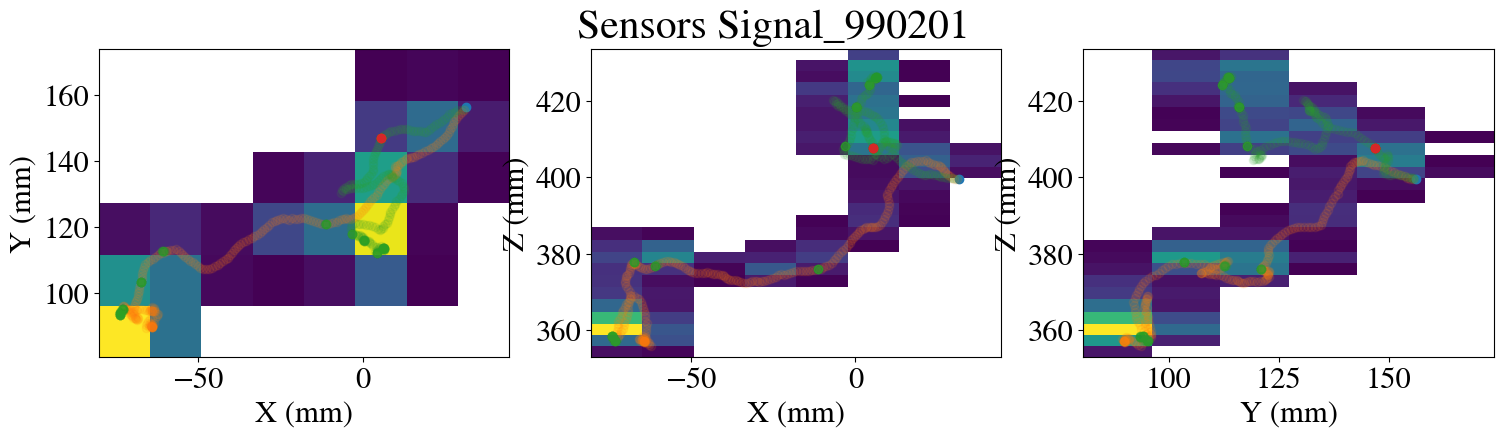

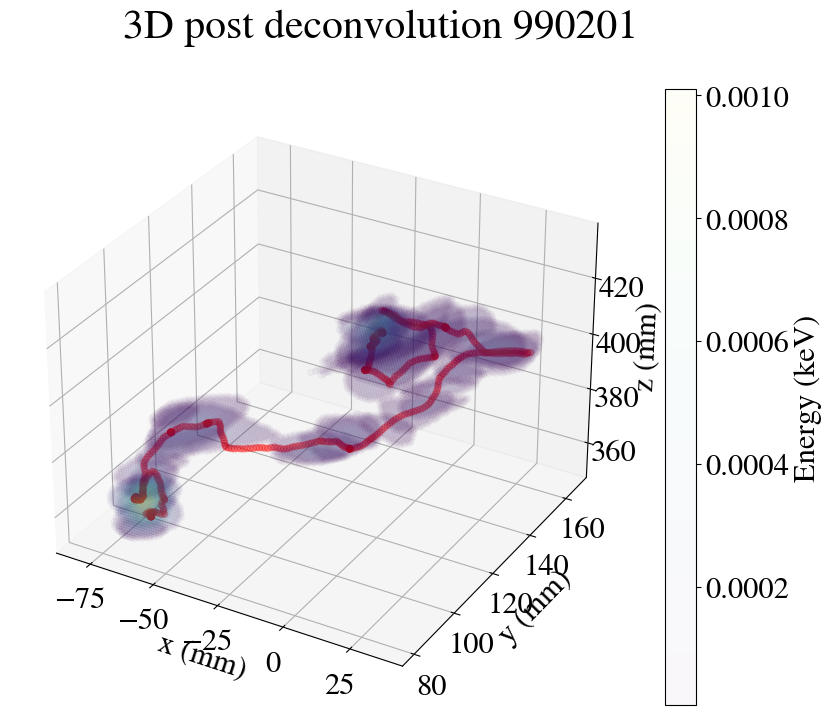

In [25]:
# relevant beersheba nonsense

pitch = 15.55


hdst = dstio.load_dst(file_path, 'DECO', 'Events')#CHITS/lowTh

hits = hdst[hdst.event == evt*2]
display(hits)

x_range, y_range, z_range, mid_x, mid_y, mid_z, min_x, min_y, min_z, max_x, max_y, max_z, xbins, ybins, zbins = func.collect_max_min(hits)
# then applying transformations to convert to 'SiPM outputs'
fig, axes = plt.subplots(1, 3, figsize=(18, 4))


xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

for pid, df in this_evt_true_info.groupby('particle_name'):

    xt = df.x
    yt = df.y
    zt = df.z
    et = df.energy*1000

   
    if (pid == 'gamma') or (pid == 'Xe131') or (pid == 'Xe129'):
        axes[0].scatter(xt, yt,  alpha=1, label = str(pid))
        axes[1].scatter(xt, zt,  alpha=1, label = str(pid))
        axes[2].scatter(yt, zt,  alpha=1, label = str(pid))
    else:
        axes[0].scatter(xt, yt,  alpha=0.1, label = str(pid))
        axes[1].scatter(xt, zt,  alpha=0.1, label = str(pid))
        axes[2].scatter(yt, zt,  alpha=0.1, label = str(pid))


fig.suptitle('Sensors Signal_' + str(evt), fontsize=30)

fig.show()

x = hits.X
y = hits.Y
z = hits.Z
e = hits.E

xt = this_evt_true_info.x
yt = this_evt_true_info.y
zt = this_evt_true_info.z
et = this_evt_true_info.energy*1000

fig = plt.figure()
fig.suptitle('3D post deconvolution ' + str(evt), fontsize=30)
ax = fig.add_subplot(111, projection='3d')
#em = e > 0.00005 # eliminate small things for measurement
#p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
p = ax.scatter(x, y, z, c=e, alpha=0.03, cmap='viridis')
q = ax.scatter(xt, yt, zt, alpha = 0.3, color = 'red')
cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
#ax.view_init(-160, 90)
plt.show()


/tmp/ipykernel_19636/2312545179.py:71: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


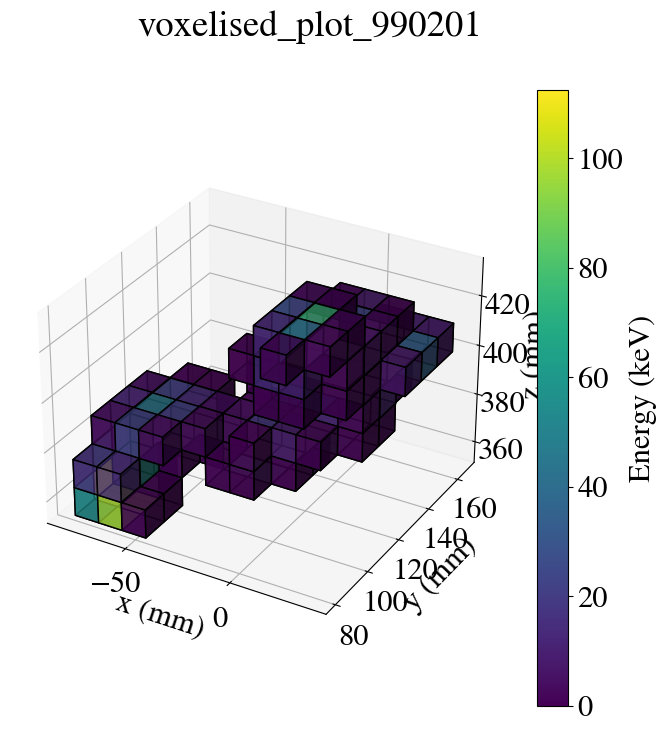

In [26]:

# need a sphere plotter for the blob radii
def plt_sphere(list_center, list_radius):
  for c, r in zip(list_center, list_radius):

    print(c)
    # draw sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x_s = r*np.cos(u)*np.sin(v)
    y_s = r*np.sin(u)*np.sin(v)
    z_s = r*np.cos(v)

    ax.plot_surface(x_s-c[0], y_s-c[1], z_s-c[2], color=np.random.choice(['r']), alpha=0.2)



base_vsize = 12 #mm
the_hits = []

xs = x
ys = y
zs = z
es = e

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)
#plt_sphere([(-track.blob2_x.values[0], -track.blob2_y.values[0], -track.blob2_z.values[0])], [blobR])

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)


sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

fig.suptitle('voxelised_plot_' + str(evt))

#ax.view_init(-160, 90)

plt.show(fig)



[Voxel(-74.32500000000269, 85.88749999999737, 358.6350164062475, E=55.06893019731113), Voxel(-74.32500000000269, 85.88749999999737, 370.14663046874836, E=15.78130298495878), Voxel(-74.32500000000269, 96.51249999999811, 358.6350164062475, E=112.53372850860595), Voxel(-74.32500000000269, 96.51249999999811, 370.14663046874836, E=33.554981208169444), Voxel(-74.32500000000269, 96.51249999999811, 381.65824453124924, E=3.7534923419345008), Voxel(-74.32500000000269, 107.13749999999888, 358.6350164062475, E=2.5149781120395422), Voxel(-74.32500000000269, 107.13749999999888, 370.14663046874836, E=1.1904030062238244), Voxel(-74.32500000000269, 107.13749999999888, 381.65824453124924, E=12.056637505928732), Voxel(-74.32500000000269, 117.76249999999962, 381.65824453124924, E=4.369330074275754), Voxel(-62.7250000000021, 85.88749999999737, 358.6350164062475, E=97.0301648807369), Voxel(-62.7250000000021, 85.88749999999737, 370.14663046874836, E=15.818689376529246), Voxel(-62.7250000000021, 96.5124999999

/tmp/ipykernel_19636/428229338.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


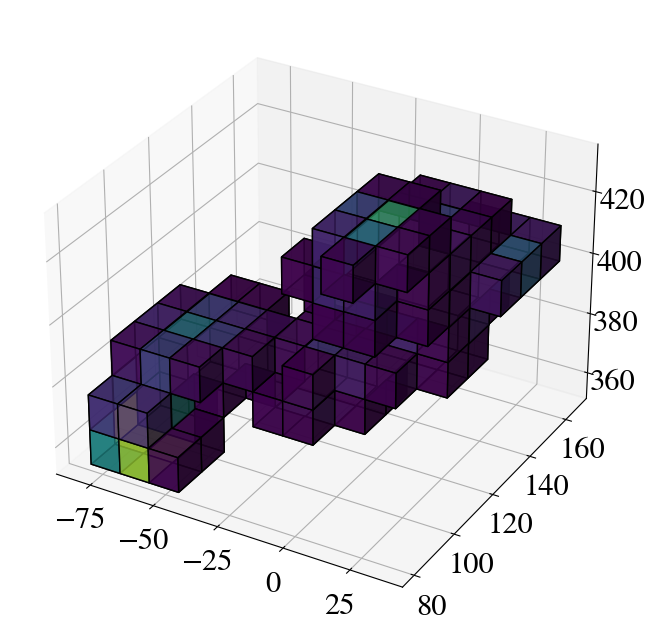

In [30]:
print(voxels)
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)
plt.show()

In [42]:
print(voxels[0].X)

-74.32500000000269


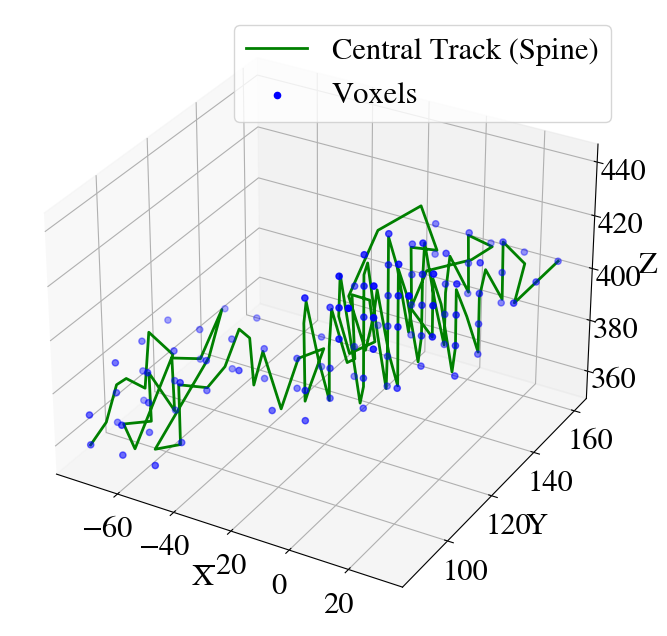